# Maximum mixed layer depth in ACCESS-OM3

Related issue: https://github.com/ACCESS-Community-Hub/access-om3-paper-1/issues/38

In [1]:
#parameters

### USER EDIT start
# esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
esm_file='/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json'
plotfolder='/g/data/tm70/cyb561/access-om3-paper-1/notebooks/mkfigs_output/2/'
dpi=300
### USER EDIT stop

import matplotlib as mpl
import os
%matplotlib inline
mpl.rcParams['figure.dpi']= dpi

os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json
Plot folder path:  /g/data/tm70/cyb561/access-om3-paper-1/notebooks/mkfigs_output/2/


In [2]:
import xarray as xr
import cf_xarray as cfxr
import cf_xarray.units
import pint_xarray
from pint import application_registry as ureg
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client
import cftime
import os
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from textwrap import wrap
xr.set_options(keep_attrs=True);  # cf_xarray works best when xarray keeps attributes by default

In [3]:
client = Client(threads_per_worker=1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33149 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:41565' processes=14 threads=14, memory=63.00 GiB>

### Define plot function

In [4]:
blue_marble = plt.imread('/g/data/ik11/grids/BlueMarble.tiff')
blue_marble_extent = (-180, 180, -90, 90)

In [5]:
def plot(dat, title=None, **kwargs):
    if title is None:
        title = dat.attrs['long_name']
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    dat.plot.contourf(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={"label": "\n".join(wrap(f"{dat.attrs['long_name']} [{dat.attrs['units']}]", 45)),
                     "fraction": 0.03, "aspect": 15, "shrink": 0.7},
        **kwargs
    )
    
    # Add blue marble land:
    ax.imshow(
        blue_marble, extent=blue_marble_extent, transform=ccrs.PlateCarree(), origin="upper"
    )
    
    plt.title(title);

### Load and plot data from ACCESS-OM3

In [6]:
exptname = os.path.basename(os.path.dirname(esm_file))

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [7]:
exptname

'25km-iaf-test-for-AK-expt-7df5ef4c'

In [8]:
geolon = datastore.search(variable="geolon").to_dask().geolon
geolat = datastore.search(variable="geolat").to_dask().geolat

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/source.py:306: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  reco

In [9]:
variable = "mlotst_max"
model_all = datastore.search(variable=variable, frequency="1mon").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    ),
    xarray_combine_by_coords_kwargs=dict(
        compat="override",
        data_vars="minimal",
        coords="minimal"
    )
)[variable].cf.assign_coords({ "longitude": geolon, "latitude": geolat })

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [10]:
##### ONLY NEEDED FOR 25km-iaf-test-for-AK-expt-7df5ef4c !!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# omit latitudes with grid bug https://github.com/ACCESS-NRI/ocean_model_grid_generator/issues/7
model_all = model_all.isel(yh=slice(10, None))
geolon = geolon.isel(yh=slice(10, None))
geolat = geolat.isel(yh=slice(10, None))

In [11]:
# for IAF
model_all = model_all.convert_calendar("proleptic_gregorian", use_cftime=True)

In [12]:
model_all.time.values[0] # initial date in data

cftime.DatetimeProlepticGregorian(1958, 1, 16, 12, 0, 0, 0, has_year_zero=True)

In [13]:
model_all.time.values[-1] # final date in data

cftime.DatetimeProlepticGregorian(1987, 12, 16, 12, 0, 0, 0, has_year_zero=True)

In [14]:
# set time range

# timerange = slice(cftime.DatetimeNoLeap(1942, 1, 1, 0, 0, 0, 0),
#                   cftime.DatetimeNoLeap(1952, 1, 1, 0, 0, 0, 0))
timerange = slice(None, None)
# datestop = model_all.time.values[-1] # final date in data
# datelist = list(cftime.to_tuple(datestop))
# datelist[0] -= 10  # last 10 years
# datestart = cftime.datetime(*datelist, calendar=datestop.calendar)
# timerange = slice(datestart, datestop)

In [15]:
model_all = model_all.sel(time=timerange)

In [16]:
%%time
model = model_all.max('time').load()

CPU times: user 4.41 s, sys: 682 ms, total: 5.1 s
Wall time: 5.62 s


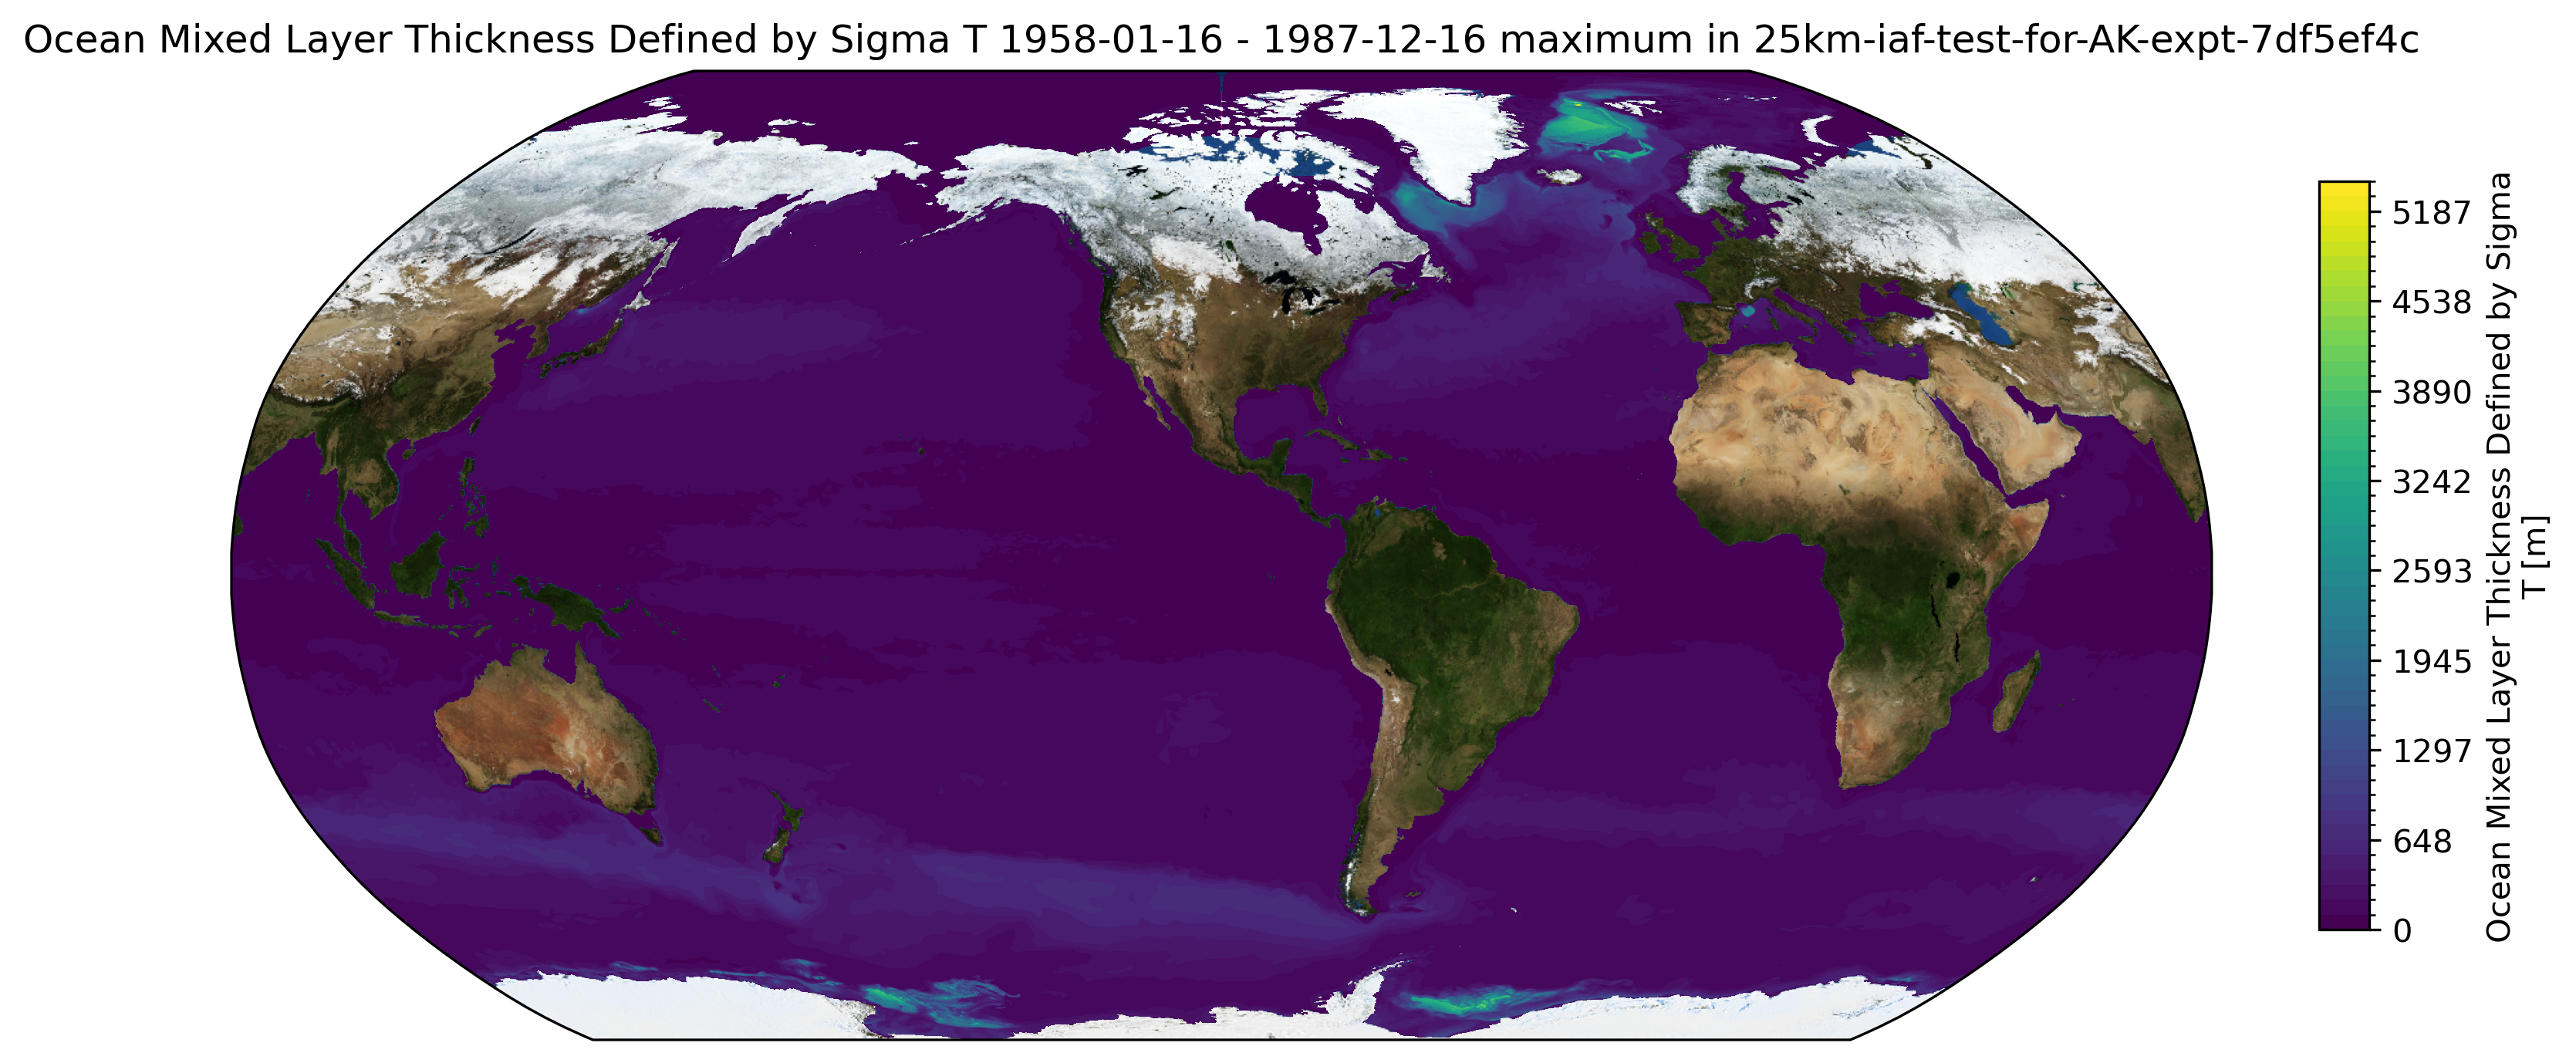

In [17]:
plot(model,
    levels=51,
    vmin=0,
    vmax=None,
    # extend="max",
    cmap='viridis',
    title=f"{model.attrs['long_name']} {model_all.time.values[0].strftime('%Y-%m-%d')} - {model_all.time.values[-1].strftime('%Y-%m-%d')} maximum in {exptname}"
    )

In [18]:
MLDobs = xr.open_dataset('/g/data/v45/aek156/notebooks/github/ACCESS-Community-Hub/access-om3-25km-paper-1/notebooks/DeBoyerMontegut2022a/mld_dr003_ref10m_v2023.nc')['mld_dr003']
MLDobs.attrs['units'] = MLDobs.attrs['unit']  # fix so plot works

# TODO: append copy of westernmost data to eastern end to avoid gap in plot

In [19]:
# small BUG: mean of monthly means is not mean of days in that month (eg Feb gets slightly more heavily weighted)
MLDobs_JFM_mean = MLDobs.isel(time=[0, 1, 2]).mean('time').load()
MLDobs_JAS_mean = MLDobs.isel(time=[6, 7, 8]).mean('time').load()

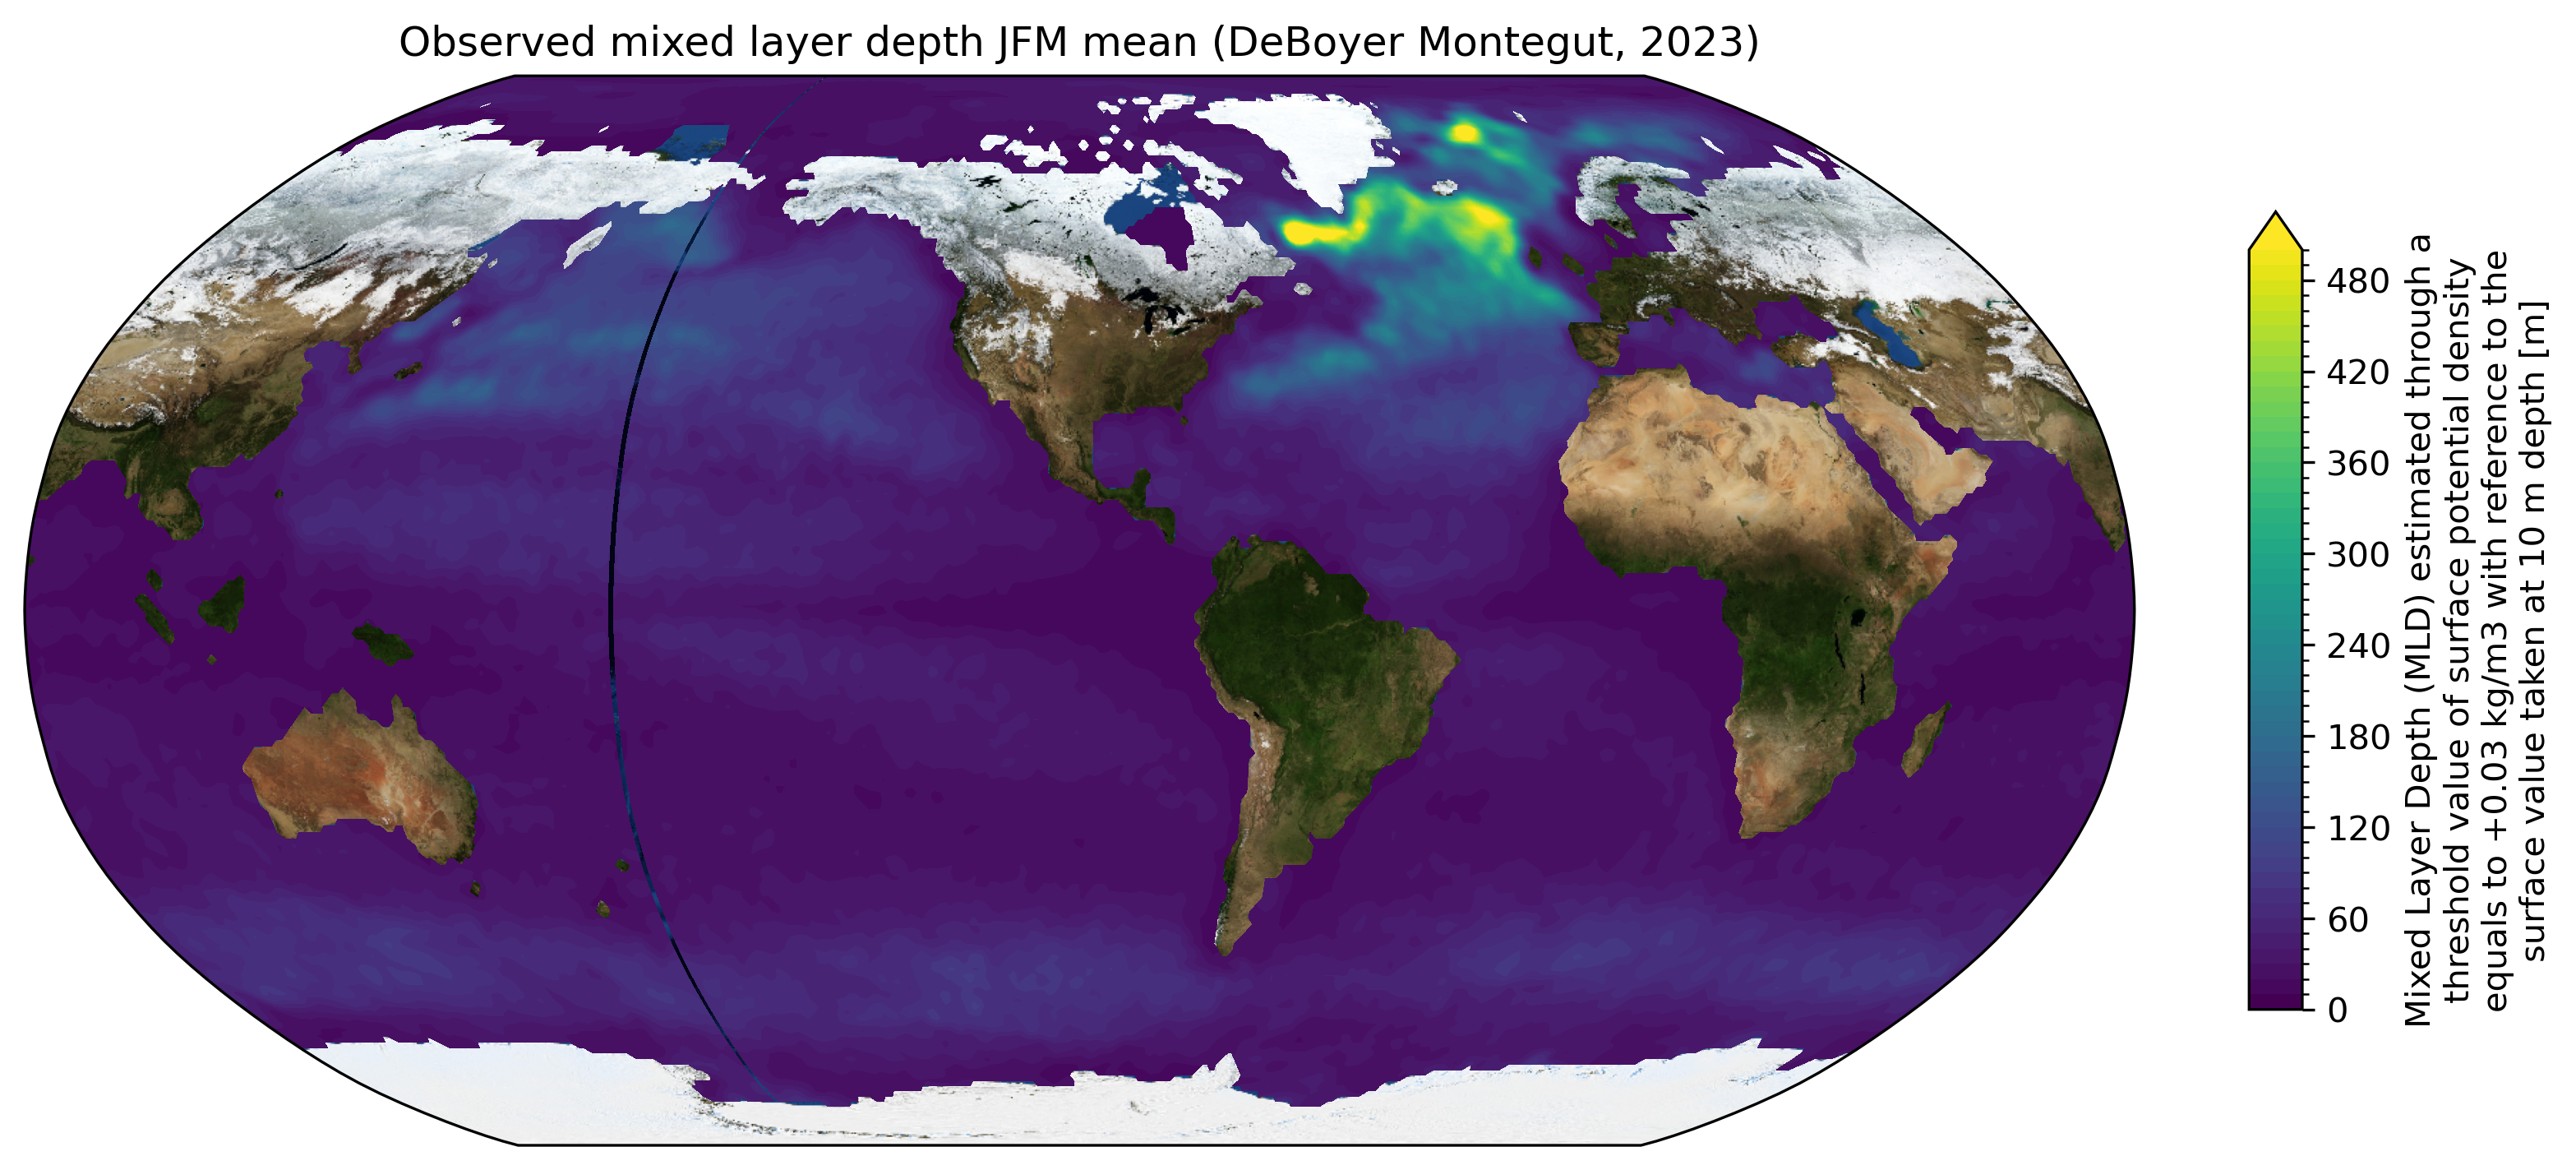

In [20]:
plot(MLDobs_JFM_mean,
    levels=51,
    vmin=0,
    vmax=500,
    extend="max",
    cmap='viridis',
    title=f"Observed mixed layer depth JFM mean (DeBoyer Montegut, 2023)"
    )

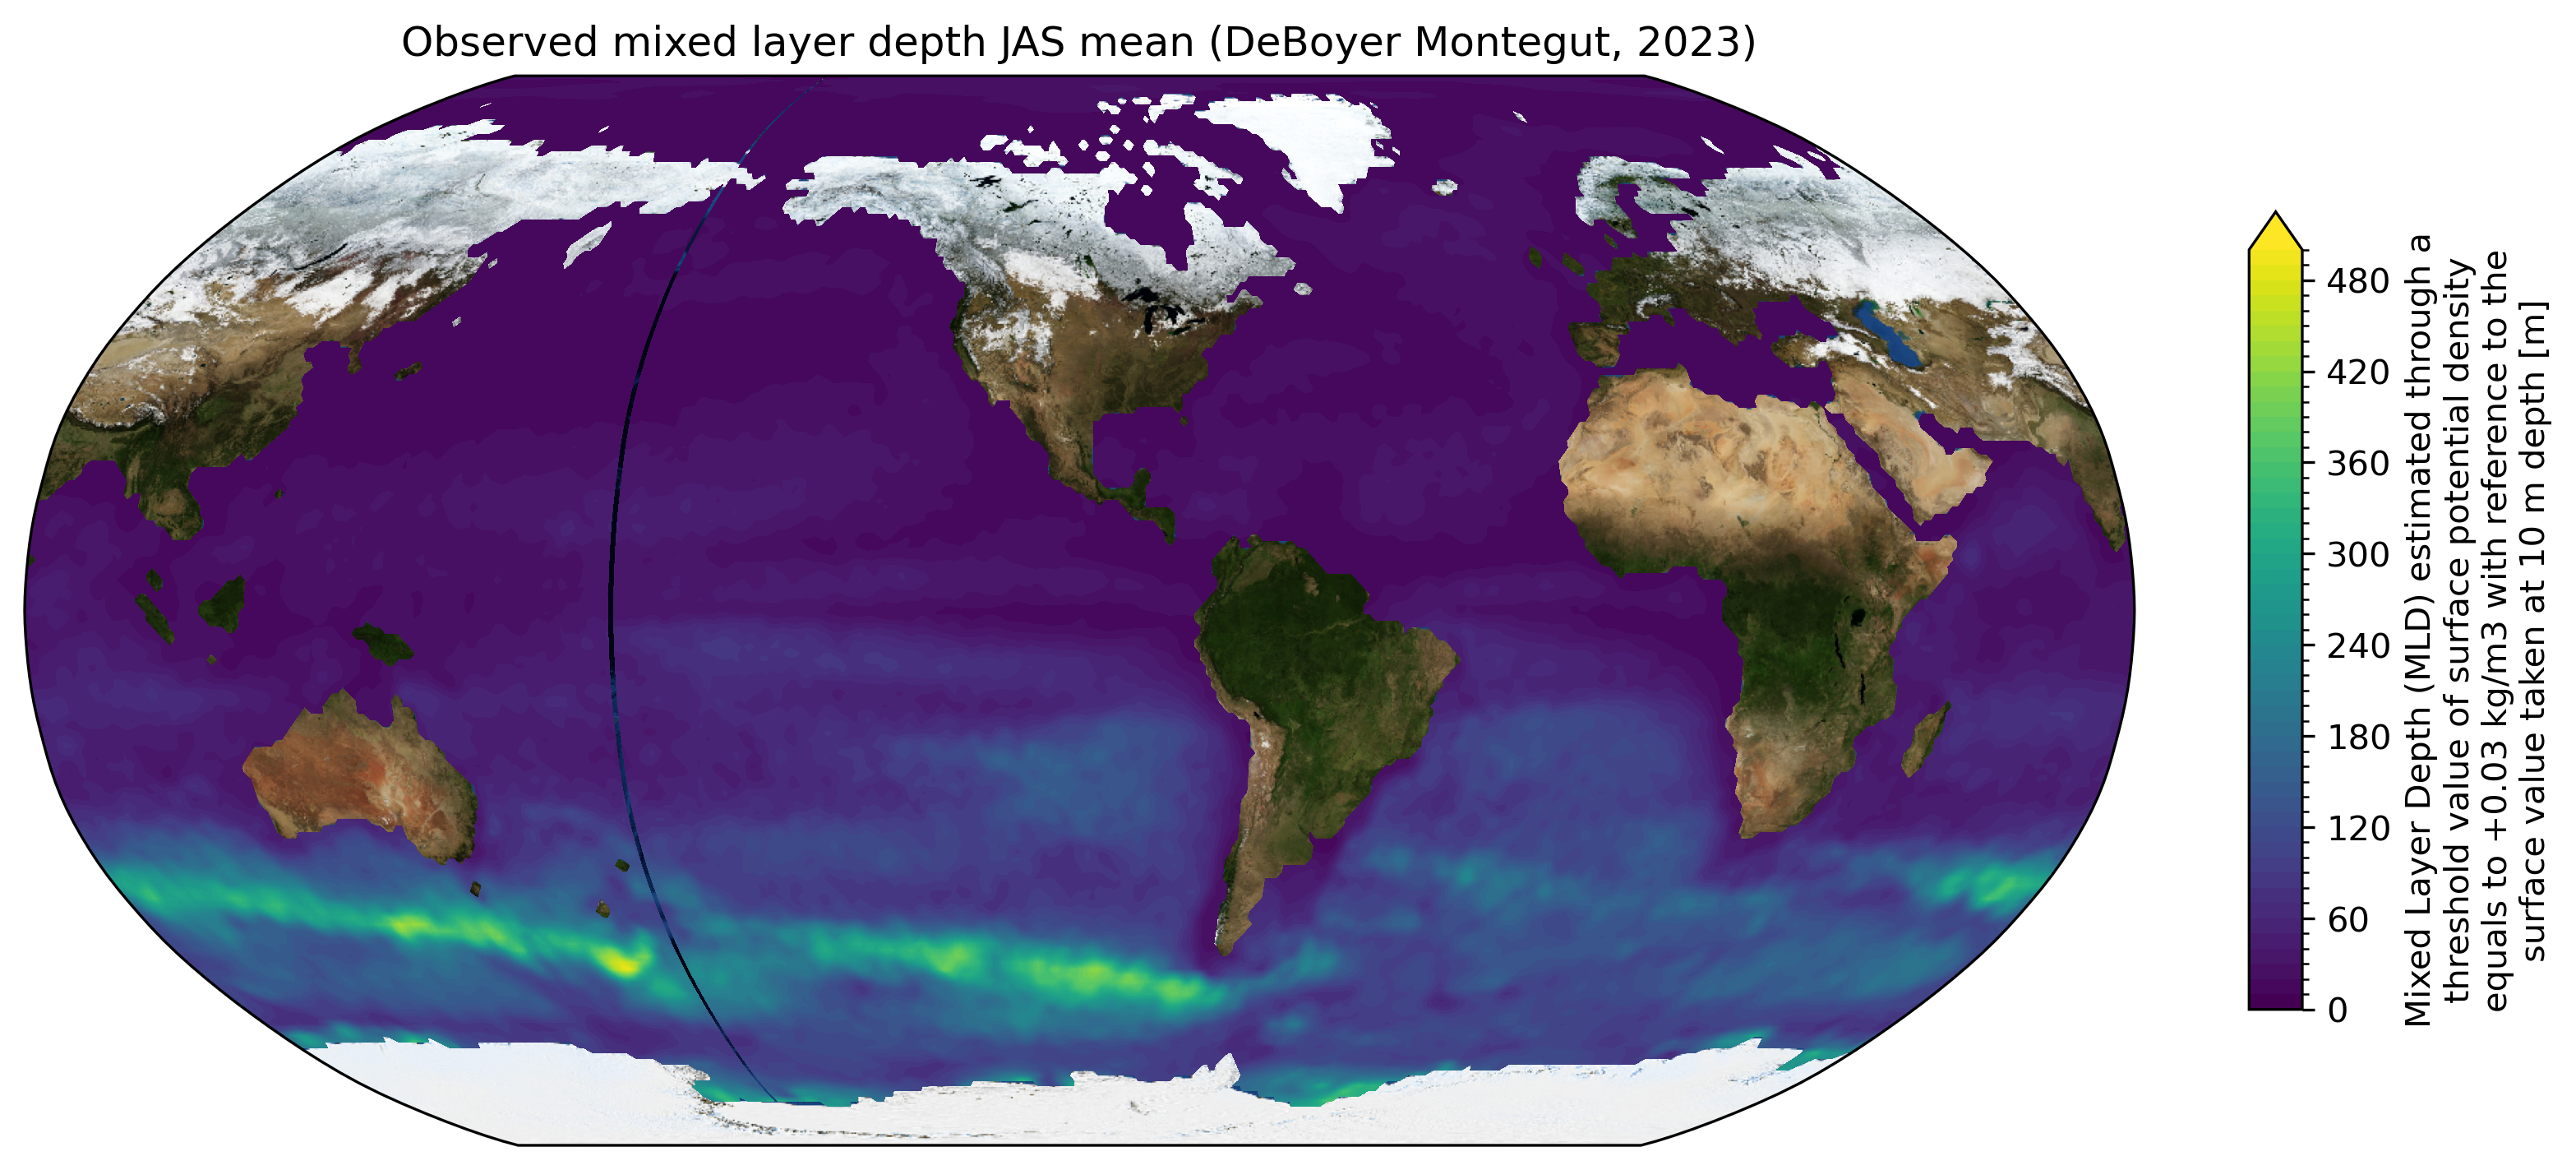

In [21]:
plot(MLDobs_JAS_mean,
    levels=51,
    vmin=0,
    vmax=500,
    extend="max",
    cmap='viridis',
    title=f"Observed mixed layer depth JAS mean (DeBoyer Montegut, 2023)"
    )

In [22]:
client.close()